In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# global defaults for plots - optional
sns.set_theme(style="ticks",
              palette="Set2",
              font_scale=1.7,
              rc={
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

## Exercise 1.1 The leaky integrate and fire neuron

In Lab 1 we simulated the passive membrane dynamics of a neuron:

$$ \tau \frac{\mathrm{d}V}{\mathrm{d}t} = -(V-E_m) + \frac{I_{ext}}{g_m} $$

The leaky integrate and fire model obeys the above equation while below spiking threshold. Now, we will add spikes to the model. To do so, we add the following spike-reset rule: if $V (t) \geq V_{threshold}$ then we immediately set $V (t) \to V_{reset}$.

* Modify the code for the passive dynamics in Lab 1 to incorporate this spike-reset rule. To do this, you can add an if-then statement inside your loop over time steps. You will also need to store spike times for later use. Using this code, set $V_{threshold} = −50$ mV, $V_{reset} = −75$ mV and try running the simulation with different values of input current and time constant and plot the membrane potential in each case.

How does each parameter influence the spiking activity?


In [22]:
# LIF neuron class
class LIF_Neuron:
    """
    Leaky Integrate-and-Fire Neuron
    """
    def __init__(self):
        # simulation params
        self.n_neurons = 1
        # neuron params
        self.V_init = -70
        self.E_m = -70
        self.tau = 10
        self.g_m = 1
        self.I_ext = 21
        self.V_theta = -50
        self.V_reset = -75
        # results
        self.V = np.array([])
        self.spikes = np.array([])
        self.spike_times = np.array([])
        self.ISI = np.array([])
    
    def euler_solve(self, N_t, dt,  V_init, I_ext, tau):
        """
        Euler method to numerically solve LIF neuron ODE
        N_t: number of time steps
        dt: time step size
        V_init: initial membrane potential vector
        I_ext: external current vector
        tau: time constant vector
        """
        self.n_neurons = V_init.shape[0]
        # N_t+1 rows (N_t+init), n_neurons columns
        # Column is V of a SPECIFIC neuron OVER time
        # Row is V for ALL neurons AT a particular time
        V = np.zeros([N_t+1, self.n_neurons])
        V[0,:] = V_init[:]
        spikes = np.zeros(V.shape)
        # 
        for t in range(1,N_t+1):
            dV = (-(V[t-1] - self.E_m) + I_ext/self.g_m)
            V[t] = V[t-1] + dt * dV / tau
            # check spike and reset
            spiked = (V[t] >= self.V_theta)
            # boolean value selector
            V[t] = self.V_reset * spiked + V[t] * (spiked == 0)
            # record a spike at t
            spikes[t] = spiked * 1.0
        
        # save results
        self.V = V
        self.spikes = spikes
        self.extract_spike_times()
    
    def extract_spike_times(self):
        """
        Extract spike times from neuron-spike matrix
        """
        spike_times = []
        for n in range(self.n_neurons):
            # if any spikes in neuron n (column n)
            if np.any(self.spikes[:,n] == 1.0):
                # extracts indices of spikes (time steps)
                spike_time_steps = np.nonzero(self.spikes[:,n])
            else:
                spike_time_steps = np.array([])
            spike_times.append(spike_time_steps)
        self.spike_times = spike_times

    def compute_ISI(self, dt=0.1):
        """
        Compute Inter-Spike Intervals (ISI) for each neuron
        """
        ISI = []
        for n in range(self.n_neurons):
            spike_times = self.spike_times[n]
            if np.any(spike_times):
                if len(spike_times[0]) > 1:
                    ISI.append(np.diff(spike_times[0]*dt))
            else:
                ISI.append(np.array([None]))
            # 
            # if len(spike_times) < 2:
            #     ISI.append(np.array([None]))
            # ISI.append(np.diff(spike_times))
        self.ISI = ISI
        
    def simulate(self, n_params, values):
        combs = n_params * values
        N_t = 10000
        dt = 0.1

        V_inits = np.zeros([combs])
        V_inits[:] = self.V_init
        taus = np.zeros([combs]) + self.tau
        taus[:values] =  np.linspace(1,100, values)
        I_exts = np.zeros([combs]) + self.I_ext
        I_exts[values:] = np.linspace(0,30,5)
        print(V_inits)
        print()
        print(taus)
        print()
        print(I_exts)
        self.euler_solve(N_t, dt, V_inits, I_exts, taus)



In [23]:
# Simulation
neuron = LIF_Neuron()
neuron.simulate(n_params=2, values=5)

[-70. -70. -70. -70. -70. -70. -70. -70. -70. -70.]

[  1.    25.75  50.5   75.25 100.    10.    10.    10.    10.    10.  ]

[21.  21.  21.  21.  21.   0.   7.5 15.  22.5 30. ]


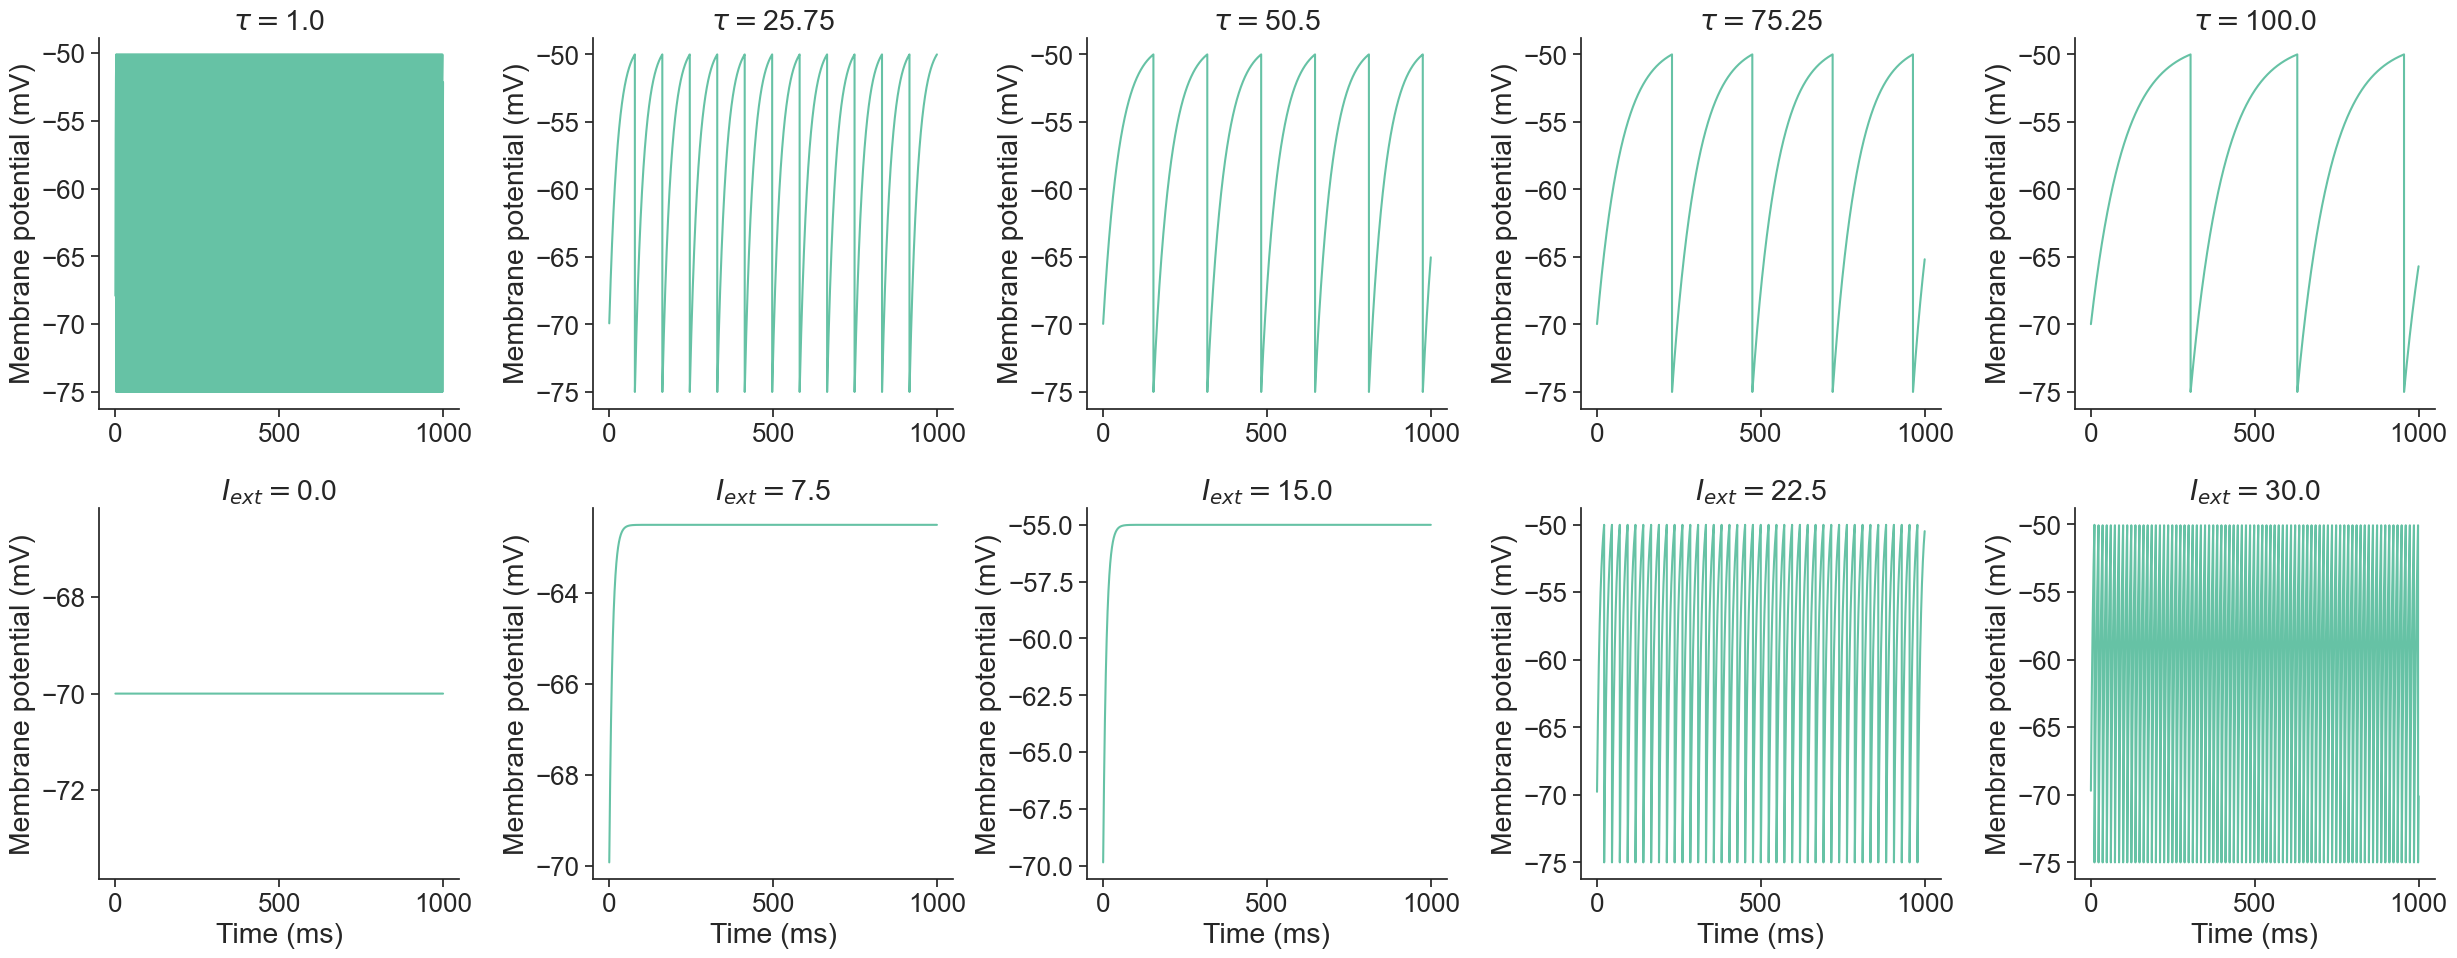

In [24]:
# Figures
n_params = 2
values = 5
combs = n_params * values
N_t = 10000
dt = 0.1

taus = np.zeros([combs]) + neuron.tau
taus[:values] =  np.linspace(1,100, values)
I_exts = np.zeros([combs]) + neuron.I_ext
I_exts[values:] = np.linspace(0,30,5)
V_spike = neuron.V

fig, ax = plt.subplots(n_params,values, figsize = (25,10))
for i in range(values):
    ax[0,i].plot(np.arange(0,N_t*dt, dt),V_spike[1:,i])
    ax[0,i].set_title('$\\tau =$'+str(taus[i]))
    ax[1,i].plot(np.arange(0,N_t*dt, dt),V_spike[1:,i+values])
    ax[1,i].set_title('$I_{ext} =$'+str(I_exts[i+values]))
    ax[0,i].ticklabel_format(useOffset=False, style = 'plain')
    ax[1,i].ticklabel_format(useOffset=False, style = 'plain')
    ax[0,i].set_ylabel('Membrane potential (mV)')
    ax[1,i].set_ylabel('Membrane potential (mV)')
    ax[1,i].set_xlabel('Time (ms)')

fig.tight_layout()
plt.show()

Answers:

**As tau increases, the frequency of spikes decreases, while peak membrane potential remain constant (because we reset it).**

**As I_ext increases, the membrane potential first slowly reaches the threshold and after 15mA begins to reset and spike frequency further increases**

## Exercise 1.2 Interspike intervals and f-I curve

For each choice of parameters, compute the interspike intervals from the stored spike times (if any). Plot the interspike interval against input current. Now do the same for the spike rate. Review the analytical expression for the f-I curve derived in lecture 5 - do your simulations agree? (you can compare the numerical and analytical results both qualitatively and quantitatively)

In [35]:
neuron.compute_ISI()
ISI = neuron.ISI
ISI_p = np.zeros([combs])
rate = np.zeros([combs])
print(len(ISI))

for i in range(combs):
    ISI_p[i] = ISI[i][0]
    rate[i] = np.sum(neuron.spikes[:,i]/(N_t*dt/1000))


10


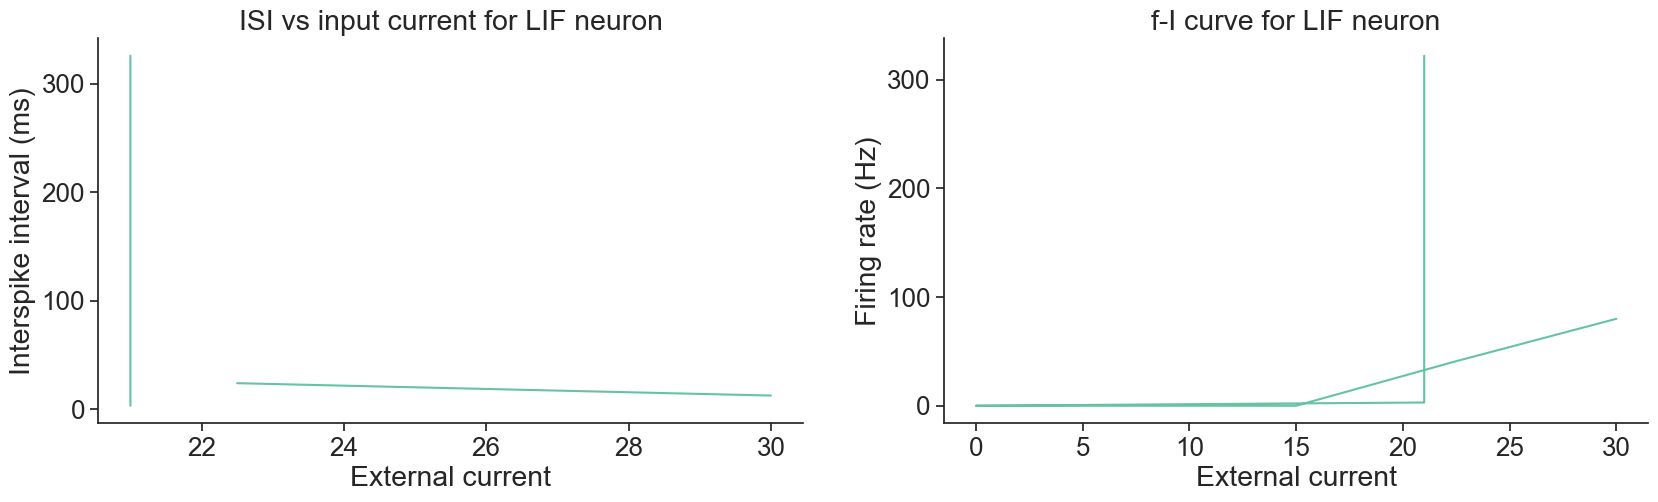

In [36]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot( I_exts, ISI_p)
ax[0].set_ylabel('Interspike interval (ms)')
ax[0].set_title('ISI vs input current for LIF neuron')
ax[0].set_xlabel('External current')
ax[1].plot(I_exts, rate)
ax[1].set_ylabel('Firing rate (Hz)')
ax[1].set_xlabel('External current')
ax[1].set_title('f-I curve for LIF neuron')
plt.show()

In [ ]:
class Noisy_LIF_Neuron(LIF_Neuron):
    """
    Noisy Leaky Integrate-and-Fire Neuron
    """
    def __init__(self):
        super().__init__()
        # neuron params
        self.rng = 5
        self.tau = 10
    
    def euler_solve(self, N_t, dt,  V_init, tau, mu_I, sigma_I):
        """
        Euler method to numerically solve LIF neuron ODE
        N_t: number of time steps
        dt: time step size
        V_init: initial membrane potential vector
        I_ext: external current vector
        tau: time constant vector
        sigma: noise standard deviation
        """
        self.n_neurons = mu_I.shape[0]
        # N_t+1 rows (N_t+init), n_neurons columns
        # Column is V of a SPECIFIC neuron OVER time
        # Row is V for ALL neurons AT a particular time
        V = np.zeros([N_t+1, self.n_neurons])

        #ensures that multiple runs of the function will result in the same draw of random numbers
        rn_seed = np.random.RandomState(seed = 5)

        V[0,:] = V_init
        spikes = np.zeros(V.shape)
        # 
        for t in range(1,N_t+1):
            dV = -(V[t-1] - self.E_m) 
            I = mu_I + sigma_I * rn_seed.randn(self.n_neurons)
            V[t] = V[t-1] + 1 / self.tau + dt * (dV + I)
            # check spike and reset
            spiked = (V[t] >= self.V_theta)
            # boolean value selector
            V[t] = self.V_reset * spiked + V[t] * (spiked == 0)
            # record a spike at t
            spikes[t] = spiked * 1.0
        
        # save results
        self.V = V
        self.spikes = spikes
        # self.noise = noise
        self.extract_spike_times()
    
    def simulate(self):
        # combs = n_params * values
        N_t = 1000
        dt = 1

        values = 5
        sigma_I = 5
        mu_Is = np.linspace(0,20,values)

        V_inits = np.zeros([values]) + self.V_init
        taus = np.zeros([values]) + self.tau
        # taus[:values] =  np.linspace(1,100, values)
        # I_exts = np.zeros([combs]) + self.I_ext
        # I_exts[values:] = np.linspace(0,30,5)
        
        print(V_inits)
        print()
        print(taus)
        print()
        print(I_exts)
        self.euler_solve(N_t, dt, V_inits, self.tau, mu_Is, sigma_I)

In [ ]:
noisy_neuron = Noisy_LIF_Neuron()
noisy_neuron.simulate()

[-70. -70. -70. -70. -70.]

[10. 10. 10. 10. 10.]

[21.  21.  21.  21.  21.   0.   7.5 15.  22.5 30. ]


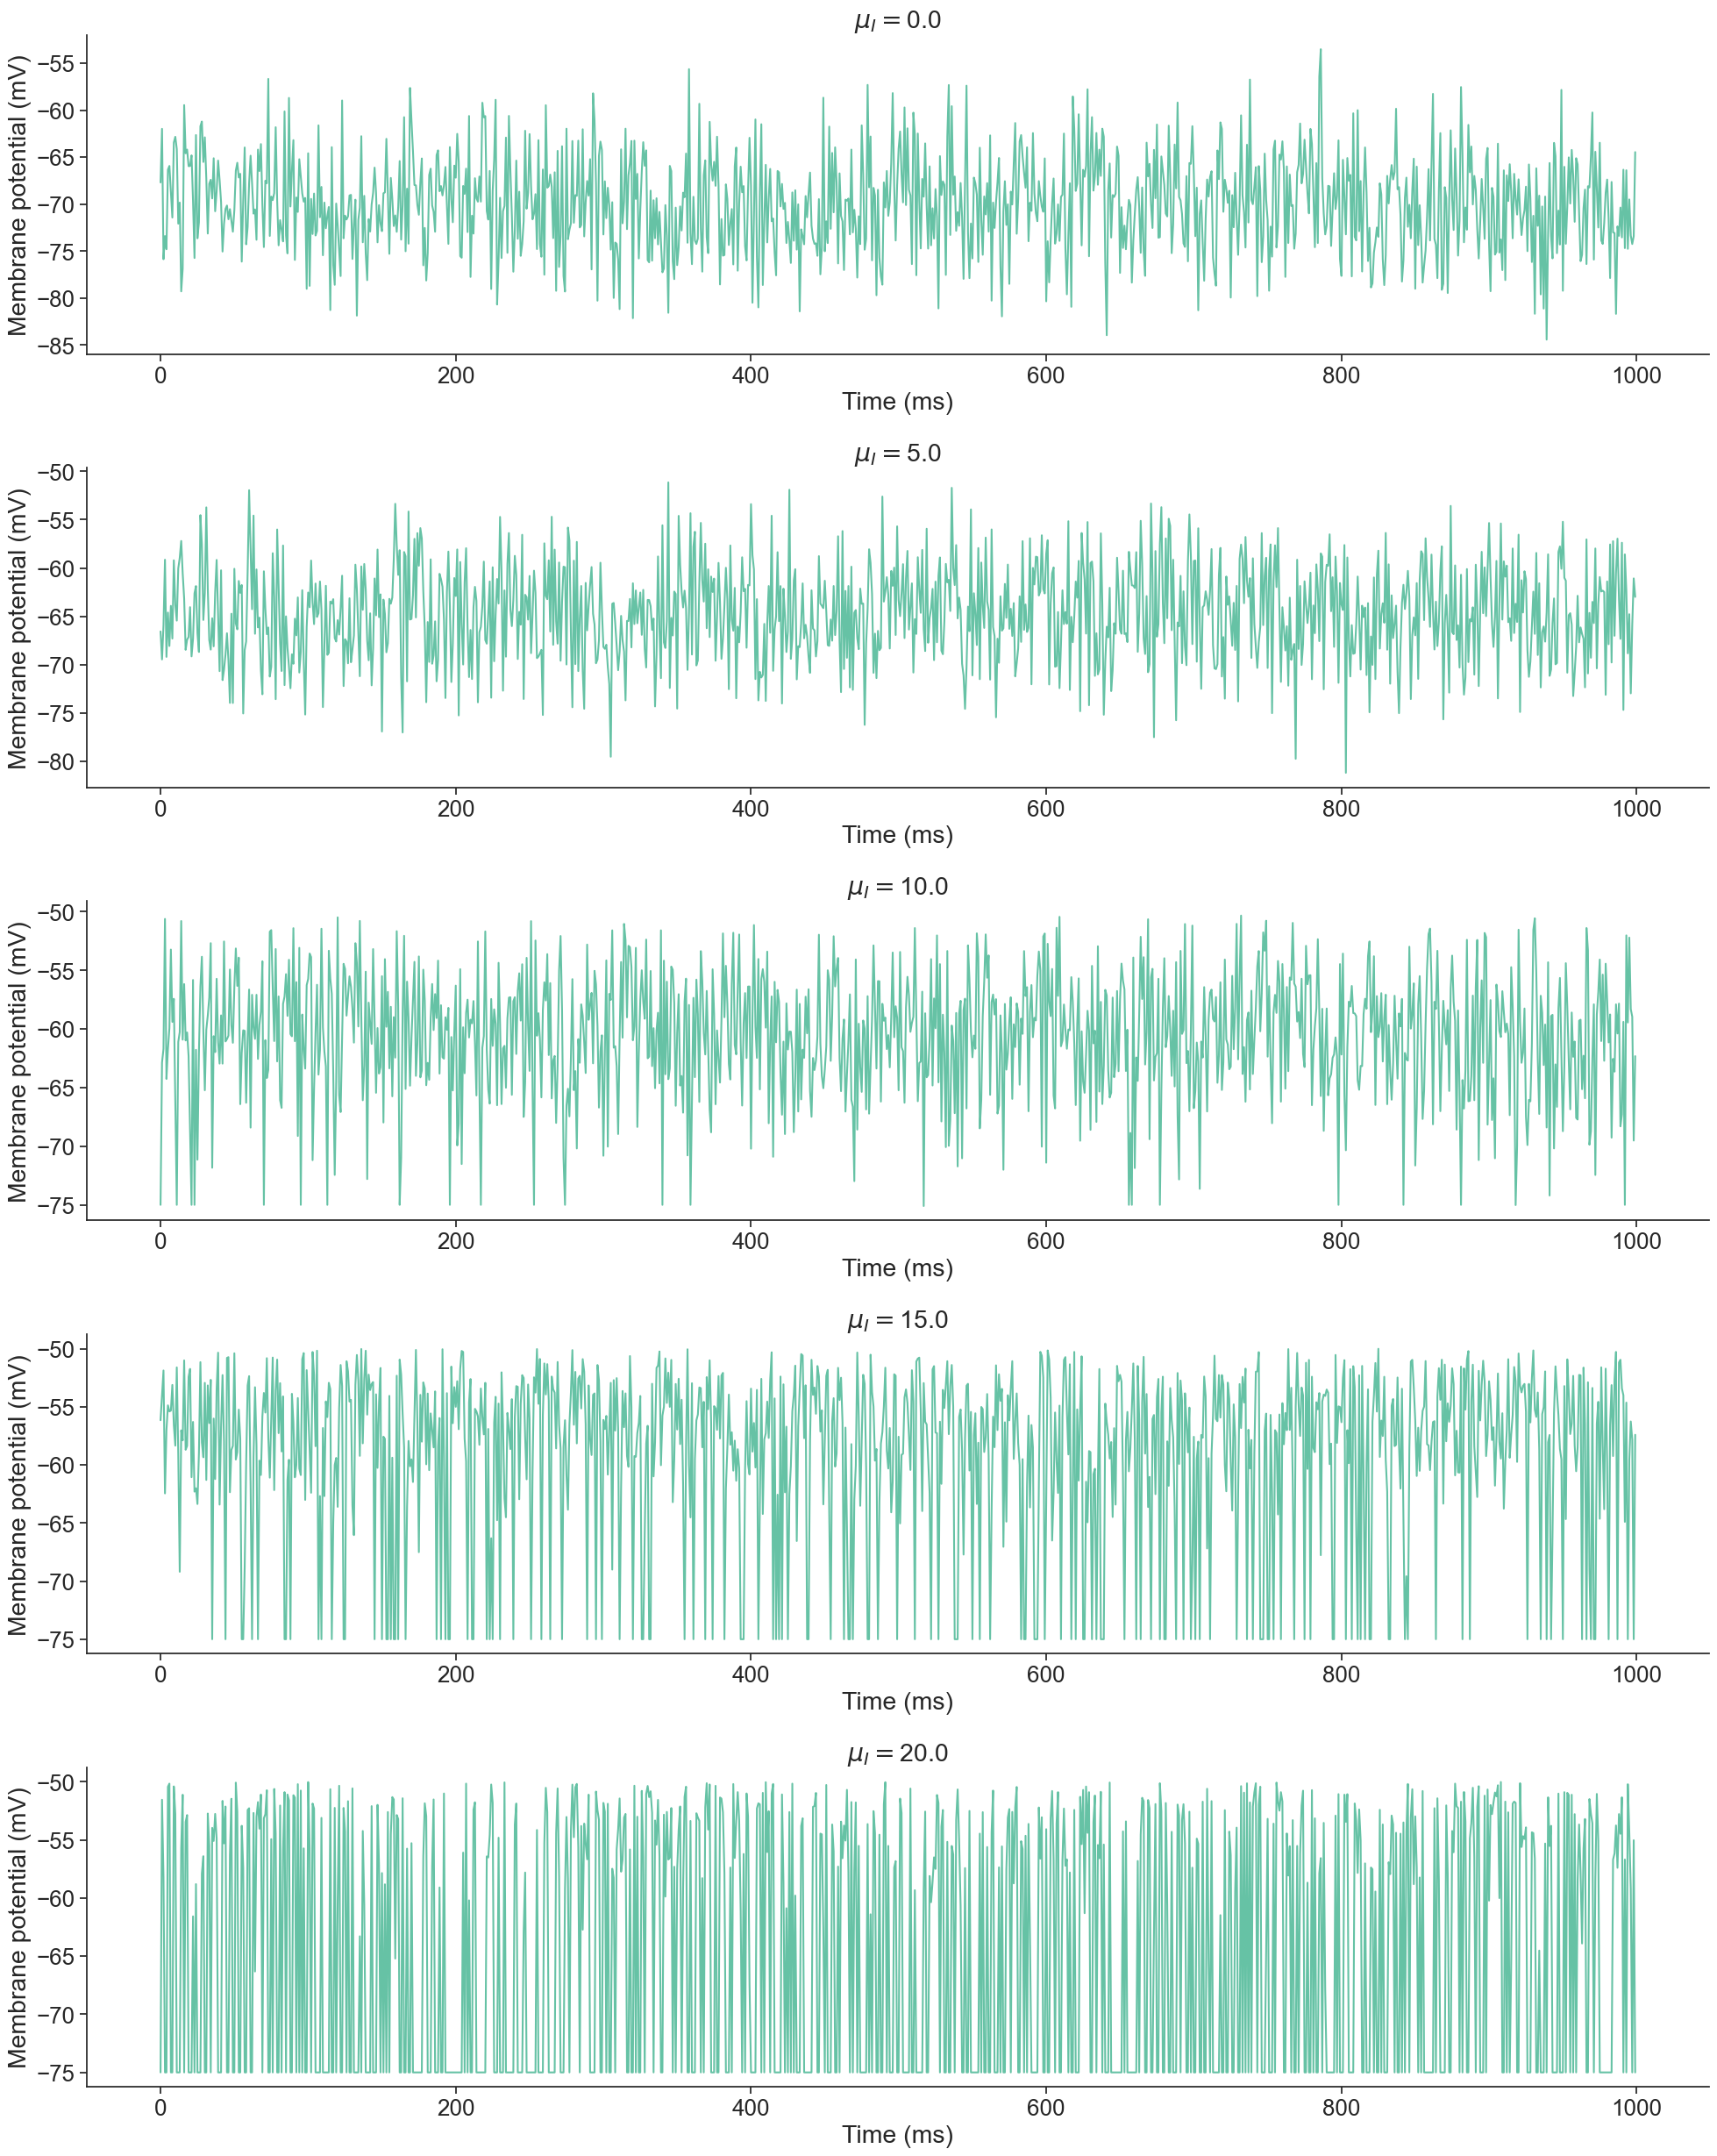

In [ ]:
N_t = 1000
dt = 1
V = noisy_neuron.V
spikes_t = noisy_neuron.spikes
mu_Is = np.linspace(0,20,values)

fig, ax = plt.subplots(5,1, figsize = (20,25))
for i in range(values):
    ax[i].plot(np.arange(0,N_t*dt, dt),V[1:,i])
    ax[i].set_title('$\\mu_I =$'+str(mu_Is[i]))
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Membrane potential (mV)')
fig.tight_layout()
plt.show()

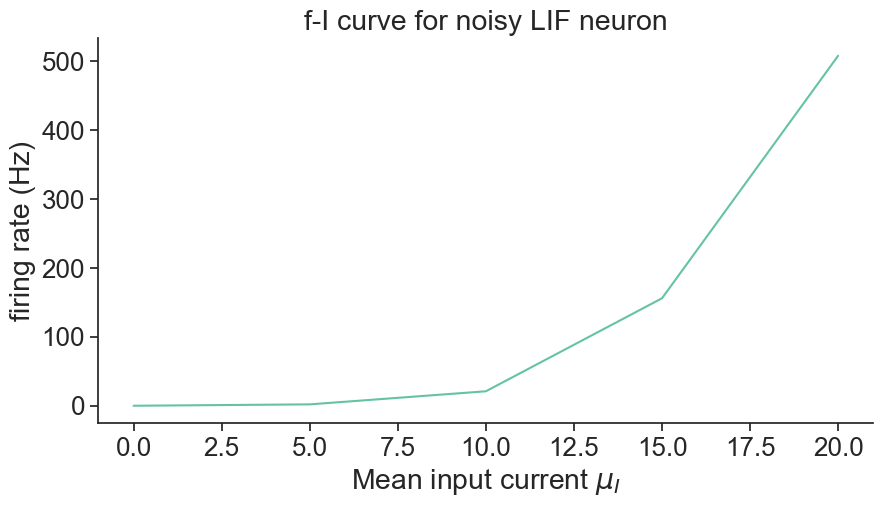

In [ ]:
spikes = noisy_neuron.spikes
rate = np.sum(spikes, axis = 0)/ ((N_t*dt)/1000)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(mu_Is, rate)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('Mean input current $\mu_I$')
ax.set_title('f-I curve for noisy LIF neuron')
plt.show()

Answers:
- **10mA and below, even with noise - no spikes**

- **15mA + $\sigma_I$ of 5, sometimes hits 20mA, which pushes the potential to -50 (threshold) and causes the spike**

- **20mA and above - stable spike intervals**

- **The effect of noise removes the hard threshold and smoothes out the f-I curve - firing rate gradually increases, as the $\sigma_I$ randomly hits sometimes**

## Exercise 2.2 - Interspike intervals

Now we will compute interspike interval distributions for different choices of parameters.
* Try varying both $\mu_I$ and $\sigma_I$.
* Make histograms of the interspike interval distribution for simulations with various parameter values (use `matplotlib.hist`).
* How does the shape of the distribution depend on the input parameters? (You can increase the number of simulation timesteps if you need to get a larger sample size).

In [ ]:
values = 5
params = 2
combs = values*params
sigma_Is = np.zeros([combs]) + 15
mu_Is = np.zeros([combs]) + 15
sigma_Is[:values] = np.linspace(10,100,values)
mu_Is[values:] = np.linspace(0,20, values)

N_t = 50000
dt = 1


sigma_Is = np.zeros([combs]) + 15
mu_Is = np.zeros([combs]) + 15
sigma_Is[:values] = np.linspace(10,100,values)
mu_Is[values:] = np.linspace(0,20, values)


V_inits = noisy_neuron.V_init
taus = noisy_neuron.tau
# taus[:values] =  np.linspace(1,100, values)
# I_exts = np.zeros([combs]) + self.I_ext
# I_exts[values:] = np.linspace(0,30,5)

# print(V_inits)
# print()
# print(taus)
# print()
# print(I_exts)
noisy_neuron.euler_solve(N_t, dt, V_inits, taus, mu_Is, sigma_Is)

V = noisy_neuron.V
spikes_t = noisy_neuron.spikes


noisy_neuron.compute_ISI()
ISI_raw = noisy_neuron.ISI
print(ISI_raw)


[array([], dtype=float64), array([[2, 3, 1, ..., 4, 1, 2]]), array([], dtype=float64), array([[1, 1, 1, ..., 2, 2, 1]]), array([], dtype=float64), array([[4, 3, 1, ..., 1, 2, 1]]), array([], dtype=float64), array([[3, 4, 2, ..., 1, 1, 6]]), array([], dtype=float64), array([[2, 2, 2, ..., 4, 3, 5]]), array([], dtype=float64), array([[13, 23,  7, ...,  6, 10, 15]]), array([], dtype=float64), array([[ 3,  2,  7, ...,  5,  3, 11]]), array([], dtype=float64), array([[2, 2, 5, ..., 2, 1, 2]]), array([], dtype=float64), array([[4, 4, 4, ..., 2, 1, 1]]), array([], dtype=float64), array([[2, 2, 1, ..., 1, 1, 2]])]


In [ ]:
fig,ax = plt.subplots(values, params, figsize = (20,3*values))
fig.suptitle(r"I=$ \mu_I + \sigma_I \cdot \eta(t) $")
for i in range(values):
    print(i)
    if len(ISI_raw[i]) and ISI_raw[i][0] is not None:
        ax[i,0].hist(ISI_raw[i], bins = 100)
    if ISI_raw[i+values][0] is not None:
        ax[i,1].hist(ISI_raw[i+values], bins = 100)
    ax[i,1].set_xlabel('ISI (ms)')
    ax[i,0].set_xlabel('ISI (ms)')
    ax[i,0].set_title('$\sigma_I=$'+str(sigma_Is[i]))
    ax[i,1].set_title('$\mu_I=$'+str(mu_Is[i+values]))
    ax[i,1].set_ylabel('Count')
    ax[i,0].set_ylabel('Count')


fig.tight_layout()
plt.show()

0


KeyboardInterrupt: 

## Exercise 2.3 - The Fano factor

To quantify the variability of spiking activity, a useful statistic is the Fano factor:
$$F = \frac{\sigma_N^2}{\mu_N}$$
where $\sigma_N$ is the variance of the spike count and $\mu_N$ is its mean.

* Compute the Fano factor of the firing rate estimated over a window of size $50ms$.
* Given what you have seen in class, what stochastic process could be used to model the activity of the LIF neuron with noisy input when $\mu_I$ is low or $\sigma_I$ is high? Why?
* Is this consistent with what you've seen in the previous question? In particular, according to what distribution should the interspike intervals be distributed for such a stochastic process?

(Optional)

Another measure of variability is the Coefficient of Variation $CoV = \frac{\sigma_N}{\mu_N}$
* How does the Fano factor you just computed compare to the Coefficient of Variation?

In [ ]:
window = 50
[np.histogram(spikes_t[i], np.arange(0, N_t*dt+dt), window) for i in range(1, values*2)]
# [np.histogram(spikes_t[i], np.arange(0, N_t*dt+dt, window))[0] for i in range(1, values*2)]
# spike_counts = np.stack()